In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle
from striprtf.striprtf import rtf_to_text
import string
from os import listdir
from datetime import datetime
from tqdm import tqdm
import cathay.re.SVO_final as SVO
import re
from cathay.config import ApplicationConfig
import boto3
from multiprocessing import Pool
import torch.multiprocessing as mp
import nltk
from transformers import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
import torch.nn.functional as F
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

Using TensorFlow backend.


In [45]:
with open('2006-2013.pkl', 'rb') as f:
    news = pickle.load(f)
# with open('2006-2013.pkl', 'rb') as f:
#     news = pickle.load(f)

In [46]:
news.head()

,id,title,date,source,document_body
0,0,Exxon Mobil offers plan to end Alaska dispute,20061020,Reuters News,"ANCHORAGE, Alaska (Reuters) - Exxon Mobil ( ..."
1,1,"Hey buddy, can you spare $600 for a Google share?",20061020,Reuters News,SAN FRANCISCO/NEW YORK (Reuters) - Wall Stre...
2,2,AOL CEO says sales may shrink for two years -p...,20061021,Reuters News,FRANKFURT (Reuters) - Internet service provi...
3,3,"Fed to keep hawkish tone, hold rates steady",20061022,Reuters News,WASHINGTON (Reuters) - The central bank is e...
4,4,Pluspetrol says losing $2.4 mln/day in Peru pr...,20061021,Reuters News,"LIMA, Peru (Reuters) - Argentine oil company..."


In [47]:
news_dict = news.to_dict('records')

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

In [49]:
datas = []
for i in tqdm(list(set([x['date'] for x in news_dict]))):
    tmp = {}
    tmp['date'] = i
    tmp['title'] = [x['title'] for x in news_dict if x['date'] == i]
    datas.append(tmp)

100%|██████████| 2582/2582 [00:20<00:00, 124.74it/s]


In [50]:
def Tokenize(dataset):
    datas = []
    for data in tqdm(dataset):
        tmp = {}
        tmp['date'] = data['date']
        titles = []
        for i in data['title']:
            titles.append(tokenizer.encode(i, add_special_tokens = False))
        
#         max_len = min(max([len(x) for x in titles]), 100)
#         tmp['title'] = padding(titles, max_len)
        tmp['title'] = titles
        datas.append(tmp)
    return datas

In [51]:
def padding(arrs, max_len):
    tmp = []
    for arr in arrs:
#         if len(arr) < max_len:
#             arr += [0] * (max_len - len(arr))
        if len(arr) > max_len:
            arr = arr[-max_len:]
        tmp.append(arr)
    return tmp

In [52]:
n_workers = 4
results = [None] * n_workers
with Pool(processes=n_workers) as pool:
    for i in range(n_workers):
        batch_start = (len(datas) // n_workers) * i
        if i == n_workers - 1:
            batch_end = len(datas)
        else:
            batch_end = (len(datas) // n_workers) * (i + 1)

        batch = datas[batch_start: batch_end]
        results[i] = pool.apply_async(Tokenize, [batch])

    pool.close()
    pool.join()

train_token = []
for result in results:
    train_token += result.get()

100%|██████████| 647/647 [00:13<00:00, 49.56it/s]


In [54]:
len(train_token)

2582

In [53]:
# with open('news_token_baseline_2006.pkl', 'wb') as f:
#     pickle.dump(train_token, f)

#### Embedding

In [2]:
with open('news_token_baseline_2006.pkl', 'rb') as f:
    train_token = pickle.load(f)

In [3]:
len(train_token)

2582

In [6]:
bert.cuda()
train_vector = []
for data in tqdm(train_token):
    tmp = {}
    tmp['date'] = data['date']
    
    title = []
    for i in data['title']:
        with torch.no_grad():
            a = bert(torch.tensor(i).unsqueeze(-1).cuda())[0]
            a = a.view(a.shape[0], a.shape[2])
            a = a.mean(0)
            title.append(a)
    
    tmp['title'] = torch.stack(title).mean(0)
    train_vector.append(tmp)

100%|██████████| 2582/2582 [23:29<00:00,  1.83it/s]


In [40]:
len(train_vector)

2113

In [7]:
with open('news_embedding_baseline_2006.pkl', 'wb') as f:
    pickle.dump(train_vector, f)

In [41]:
train_vector[0]

{'date': '20151111',
 'title': tensor([-2.9814e-01,  1.9915e-01,  8.5003e-03, -5.8908e-02,  2.5638e-01,
         -1.0496e-01,  2.3041e-01,  2.7275e-01, -2.0072e-01, -4.6973e-01,
         -2.0449e-01, -2.8971e-02, -5.3707e-02,  3.9974e-01, -3.3596e-02,
          6.0066e-01,  1.5718e-01, -2.4711e-01,  1.8134e-01, -1.9898e-01,
         -1.1929e-03, -2.2504e-01,  9.3367e-02,  1.2043e-01,  1.4268e-01,
         -3.2855e-01,  2.3271e-01,  3.0097e-01, -2.2992e-01, -2.1422e-01,
          5.4601e-03, -2.2308e-01, -3.4576e-02,  2.9997e-01, -1.8468e-02,
          2.5136e-02,  1.1427e-01, -1.5328e-01, -2.0123e-01,  3.3301e-02,
         -2.0474e-01, -3.2093e-01,  1.0514e-01, -8.4798e-02,  1.3630e-01,
         -2.3105e-01, -3.3950e-01, -3.7217e-02,  7.6257e-02, -2.2213e-01,
         -2.2348e-03,  3.6943e-01,  4.3467e-01, -2.7031e-01,  4.7039e-02,
          4.4158e-01, -3.6026e-01, -1.0059e-01, -1.1358e-01, -2.6137e-01,
          4.8928e-01, -2.8048e-01,  3.4601e-01, -4.5943e-01,  4.4375e-01,
        

# BERT + LSTM

In [2]:
with open('news_embedding_baseline_1.pkl', 'rb') as f:
    train_vector = pickle.load(f)

In [3]:
price = pd.read_csv('^TWII.csv')
price['Date'] = price['Date'].apply(lambda x:x.replace('-', ''))
price = price.dropna()
price['return1'] = price.shift(-1)['Adj Close'] / price['Adj Close']
price['return2'] = price.shift(-2)['Adj Close'] / price['Adj Close']
price['return3'] = price.shift(-3)['Adj Close'] / price['Adj Close']
# price['return4'] = price.shift(-3)['Adj Close'] / price['Adj Close']
# price['return5'] = price.shift(-3)['Adj Close'] / price['Adj Close']

price = price.dropna()
price['return'] = price.apply(lambda x:max([x['return1'], x['return2'], x['return3']]), axis=1)
# price['down'] = price.apply(lambda x:min([x['return1'], x['return2'], x['return3']]), axis=1)
price = price.reset_index(drop=True)

In [157]:
# price = pd.read_csv('^TWII.csv')
# price['Date'] = price['Date'].apply(lambda x:x.replace('-', ''))
# price = price.dropna()
# price['return'] = price.shift(-3)['Adj Close'] / price['Adj Close']
# price = price.dropna()

In [4]:
price['label'] = 0
price.loc[price[price['return'] > 1.001].index, 'label'] = 1
# price['label'] = 1
# price.loc[price[price['return'] < 0.9999].index, 'label'] = 0
# price.loc[price[price['return'] >= 1.0001].index, 'label'] = 1
# price.loc[price[price['return'] <= 0.9999].index, 'label'] = -1
# price = price[price['label'] != -1]
price = price[price['Date'] <= '20191130']
price = price[price['Date'] >= '20140201']
# price = price[price['Date'] >= '20061120']
# price = price[price['Date'] < '20140101']
# price = pd.concat((price[price['Date'] <= '20131120'], price[price['Date'] >= '20140101']))
price = price.reset_index(drop=True)

In [5]:
from collections import Counter
a = Counter(price['label'])
a

Counter({1: 965, 0: 458})

#### Data split (日期切分) 

In [6]:
datas = dict(zip([x['date'] for x in train_vector], [x['title'] for x in train_vector]))
event = [(k, datas[k]) for k in sorted(datas.keys())]
dates = [x[0] for x in event]
event_embedding = [np.array(x[1].cpu()) for x in event]

In [7]:
all_data = []
for i in tqdm(range(len(price))):
    data = {}
    if price.loc[i, 'Date'] in dates:
        data['date'] = dates.index(price.loc[i, 'Date'])
    tmp = int(price.loc[i, 'Date'])
    while str(tmp) not in dates:
        tmp -= 1
    data['date'] = dates.index(str(tmp))
    data['label'] = price.loc[i, 'label']
    all_data.append(data)

100%|██████████| 1423/1423 [00:00<00:00, 6956.29it/s]


In [8]:
# import random
# random.shuffle(all_data)

In [8]:
# all_data = all_data[:-20]
test = all_data[-int(len(all_data)*0.1):]
tmp = all_data[:int(len(all_data)*0.9)+1]
valid = tmp[-int(len(tmp)*0.1):]
train = tmp[:int(len(tmp)*0.9)]
print('Train: ', len(train))
print('Valid:' , len(valid))
print('Test: ', len(test))

Train:  1152
Valid: 128
Test:  142


In [9]:
print(len([x for x in valid if x['label'] == 1])/len(valid))
print(len([x for x in test if x['label'] == 1])/len(test))

0.734375
0.6408450704225352


In [16]:
train[0]

{'date': 35, 'label': 1}

## Model

In [10]:
class EventDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return dict(self.data[index])
    
    def collate_fn(self, datas):
        batch = {}
        
        batch['token'] = torch.tensor([list(range(x['date'] - 29, x['date'] + 1)) for x in datas])
#         batch['label'] = torch.tensor([self._label(x['label']) for x in datas])
        batch['label'] = torch.tensor([x['label'] for x in datas])
        
        return batch
    
    def _label(self, label):
        if label == -1:
            return 0
        elif label == 0:
            return 1
        else:
            return 2


In [21]:
train_set = EventDataset(train)
train_loader = DataLoader(train_set, collate_fn=train_set.collate_fn, batch_size=32, shuffle=True)
valid_set = EventDataset(valid)
valid_loader = DataLoader(valid_set, collate_fn=valid_set.collate_fn, batch_size=len(valid), shuffle=False)

In [11]:
class LSTMNet(nn.Module):
    def __init__(self, pretrained_embedding):
        super(LSTMNet, self).__init__()
        
        pretrained_embedding = torch.FloatTensor(pretrained_embedding)
        self.embedding = nn.Embedding(
            pretrained_embedding.size(0),
            pretrained_embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(pretrained_embedding)
        self.embedding.weight.requires_grad = False
        
        bi = True
        self.lstm = nn.LSTM(pretrained_embedding.size(1), 800, 2, dropout=0.2, bidirectional=bi, batch_first=True)
        self.lstm.apply(self.init_normal)
        
        self.hidden2out = nn.Sequential(
            nn.AvgPool1d(5),
            nn.Flatten(),
            
            nn.BatchNorm1d(800 * (1+bi) * 6),
            nn.LeakyReLU(0.4),
            nn.Linear(800 * (1+bi) * 6, 400),
            
#             nn.BatchNorm1d(200),
#             nn.LeakyReLU(0.2),
#             nn.Linear(200, 400),
            
            nn.BatchNorm1d(400),
            nn.LeakyReLU(0.4),
            nn.Linear(400, 100),
            
            nn.BatchNorm1d(100),
            nn.LeakyReLU(0.4),
            nn.Linear(100, 2)
        )
        
        self.hidden2out.apply(self.init_normal)
    
    def forward(self, event):
        x = self.embedding(event)
        out, (_, _) = self.lstm(x)
        out = out.transpose(1, 2)
        
        y = self.hidden2out(out)
        return y
    
    def init_normal(self, m):
        if type(m) == nn.Linear:
            nn.init.orthogonal_(m.weight)
#             nn.init.xavier_normal_(m.weight.data)
#             nn.init.normal_(m.bias.data)
        if type(m) == nn.LSTM:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
#                     nn.init.xavier_normal_(param.data)
                    nn.init.orthogonal_(param.data)
                elif 'weight_hh' in name:
#                     nn.init.xavier_normal_(param.data)
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    param.data.fill_(0)
#         if isinstance(m, nn.BatchNorm1d):
#             nn.init.normal_(m.weight.data, mean=0, std=0.1)
#             nn.init.constant_(m.bias.data, 0)

In [27]:
EPOCH = 100
model = LSTMNet(event_embedding)
use_gpu = torch.cuda.is_available()
if use_gpu:
    model.cuda()
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

acc_history = []
loss_history = []
valid_history = []
valid_loss = []

In [28]:
for epoch in range(EPOCH):
    model.train()
    train_loss = []
    train_acc = []
    for data in train_loader:
        if use_gpu:
            event = data['token'].cuda()
            labels = data['label'].cuda()
            
        optimizer.zero_grad()
        output = model(event)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        
        predict = output.max(1)[1]
#         predict = torch.tensor([1 if x >=0.5 else 0 for x in output]).cuda()
        acc = np.mean((labels == predict).cpu().numpy())
        train_acc.append(acc)
        train_loss.append(loss.item())
        
    print("Epoch: {}, train Loss: {:.4f}, train accuracy: {:.4f}".format(epoch + 1, np.mean(train_loss), np.mean(train_acc)))
    acc_history.append(np.mean(train_acc))
    loss_history.append(np.mean(train_loss))
    
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            if use_gpu:
                event = data['token'].cuda()
                labels = data['label'].cuda()

            output = model(event)
            loss = loss_fn(output, labels)
            predict = output.max(1)[1]
#             predict = torch.tensor([1 if x >=0.5 else 0 for x in output]).cuda()
            acc = np.mean((labels == predict).cpu().numpy())
        print("Epoch: {}, valid loss: {:.4f}, valid accuracy: {:.4f}".format(epoch + 1, loss, acc))
        valid_history.append(acc)
        valid_loss.append(loss)
        
    if np.mean(acc) >= 0.66:
        checkpoint_path = 'LSTM_baseline(3day)_{}({:.4f}).pth'.format(epoch+1, acc) 
        torch.save(model.state_dict(), checkpoint_path)
        print('model saved to %s' % checkpoint_path)

Epoch: 1, train Loss: 0.9066, train accuracy: 0.4410
Epoch: 1, valid loss: 0.6928, valid accuracy: 0.5312
Epoch: 2, train Loss: 0.8787, train accuracy: 0.4818
Epoch: 2, valid loss: 0.6997, valid accuracy: 0.4688
Epoch: 3, train Loss: 0.8757, train accuracy: 0.4766
Epoch: 3, valid loss: 0.7129, valid accuracy: 0.5156
Epoch: 4, train Loss: 0.8673, train accuracy: 0.4601
Epoch: 4, valid loss: 0.6430, valid accuracy: 0.6875
model saved to LSTM_baseline(3day)_4(0.6875).pth
Epoch: 5, train Loss: 0.8020, train accuracy: 0.5095
Epoch: 5, valid loss: 0.7200, valid accuracy: 0.5391
Epoch: 6, train Loss: 0.8106, train accuracy: 0.5139
Epoch: 6, valid loss: 0.6917, valid accuracy: 0.5781
Epoch: 7, train Loss: 0.8000, train accuracy: 0.5156
Epoch: 7, valid loss: 0.6798, valid accuracy: 0.5469
Epoch: 8, train Loss: 0.7896, train accuracy: 0.5174
Epoch: 8, valid loss: 0.7854, valid accuracy: 0.4375
Epoch: 9, train Loss: 0.7571, train accuracy: 0.5443
Epoch: 9, valid loss: 0.6863, valid accuracy: 0.56

KeyboardInterrupt: 

Epoch: 4, valid accuracy: 0.6875


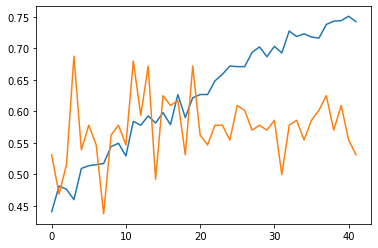

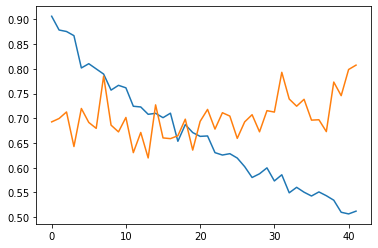

In [29]:
print('Epoch: {}, valid accuracy: {:.4f}'.format(valid_history.index(max(valid_history))+1, max(valid_history)))

import matplotlib.pyplot as plt
plt.plot(list(range(len(acc_history))), acc_history, list(range(len(valid_history))), valid_history)
plt.show()


plt.plot(list(range(len(loss_history))), loss_history, list(range(len(valid_loss))), valid_loss)
plt.show()

In [70]:
print('Epoch: {}, valid accuracy: {:.4f}'.format(valid_history.index(max(valid_history))+1, max(valid_history)))

Epoch: 185, valid accuracy: 0.6667


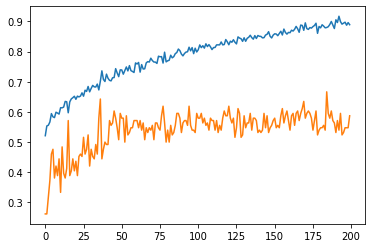

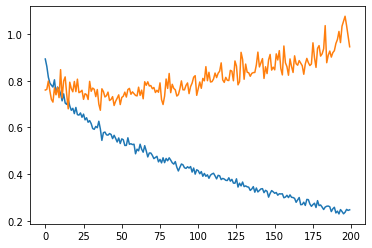

In [71]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(acc_history))), acc_history, list(range(len(valid_history))), valid_history)
plt.show()


plt.plot(list(range(len(loss_history))), loss_history, list(range(len(valid_loss))), valid_loss)
plt.show()

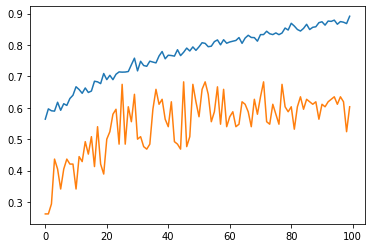

In [21]:
import matplotlib.pyplot as plt
plt.plot(list(range(100)), acc_history[:100], list(range(100)), valid_history[:100])
plt.show()

# Testing

In [40]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
valid_set = EventDataset(valid)
valid_loader = DataLoader(valid_set, collate_fn=valid_set.collate_fn, batch_size=len(valid), shuffle=False)

In [41]:
model = LSTMNet(event_embedding)
model.load_state_dict(torch.load('LSTM_baseline(3day)_20(0.6719).pth'))
use_gpu = torch.cuda.is_available()
if use_gpu:
    model.cuda()

In [42]:
model.eval()
with torch.no_grad():
    for data in valid_loader:
        if use_gpu:
            event = data['token'].cuda()
            labels = data['label'].cuda()

        output = model(event)
        predict = output.max(1)[1]
        acc = np.mean((labels == predict).cpu().numpy())
        mcc = matthews_corrcoef(data['label'], predict.cpu())
        f1 = f1_score(data['label'], predict.cpu(), average='weighted')
        pre = precision_score(labels.cpu(), predict.cpu(), average='weighted')
        recall = recall_score(labels.cpu(), predict.cpu(), average='weighted')

In [43]:
print('acc: ', acc)
print('mcc: ', mcc)
print('f1: ', f1)
print('precision', pre)
print('recall', recall)

acc:  0.671875
mcc:  0.1429762897859917
f1:  0.6686303827751195
precision 0.6656901041666667
recall 0.671875


# BERT + xgboost

In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

In [191]:
with open('news_embedding_baseline_1.pkl', 'rb') as f:
    train_vector = pickle.load(f)
datas = dict(zip([x['date'] for x in train_vector], [x['title'] for x in train_vector]))

In [226]:
with open('Event_embedding(1channel_1).pkl', 'rb') as f:
    datas = pickle.load(f)

In [227]:
price = pd.read_csv('^TWII.csv')
price['Date'] = price['Date'].apply(lambda x:x.replace('-', ''))
price = price.dropna()
price['return1'] = price.shift(-1)['Adj Close'] / price['Adj Close']
price['return2'] = price.shift(-2)['Adj Close'] / price['Adj Close']
price['return3'] = price.shift(-3)['Adj Close'] / price['Adj Close']
# price['return4'] = price.shift(-3)['Adj Close'] / price['Adj Close']
# price['return5'] = price.shift(-3)['Adj Close'] / price['Adj Close']

price = price.dropna()
price['return'] = price.apply(lambda x:max([x['return1'], x['return2'], x['return3']]), axis=1)
# price['down'] = price.apply(lambda x:min([x['return1'], x['return2'], x['return3']]), axis=1)
price = price.reset_index(drop=True)

In [228]:
price['label'] = 0
price.loc[price[price['return'] > 1.001].index, 'label'] = 1
# price['label'] = 1
# price.loc[price[price['return'] < 0.9999].index, 'label'] = 0
# price.loc[price[price['return'] >= 1.001].index, 'label'] = 1
# price.loc[price[price['return'] <= 0.999].index, 'label'] = -1
price = price[price['Date'] <= '20191130']
price = price[price['Date'] >= '20140201']
# price = price[price['Date'] >= '20061120']
# price = price[price['Date'] < '20140101']
# price = pd.concat((price[price['Date'] <= '20131120'], price[price['Date'] >= '20140101']))
price = price.reset_index(drop=True)

In [229]:
event = [(k, datas[k]) for k in sorted(datas.keys())]
dates = [x[0] for x in event]
# event_embedding = [np.array(x[1].cpu()) for x in event]
event_embedding = [np.array(x[1]) for x in event]

In [230]:
all_data = []
for i in tqdm(range(len(price))):
    data = {}
    if price.loc[i, 'Date'] in dates:
        data['date'] = dates.index(price.loc[i, 'Date'])
    tmp = int(price.loc[i, 'Date'])
    while str(tmp) not in dates:
        tmp -= 1
    data['date'] = dates.index(str(tmp))
    data['label'] = price.loc[i, 'label']
    all_data.append(data)

100%|██████████| 1423/1423 [00:00<00:00, 3243.43it/s]


In [231]:
all_data_x = []
all_data_y = []
for i in tqdm(all_data):
    all_data_x.append(np.array(event_embedding[i['date']-29:i['date']+1]).flatten())
    all_data_y.append(i['label'])

100%|██████████| 1423/1423 [00:00<00:00, 25715.30it/s]


In [232]:
test_x = all_data_x[-int(len(all_data_x)*0.1):]
tmp = all_data_x[:int(len(all_data_x)*0.9)+1]
valid_x = tmp[-int(len(tmp)*0.1):]
train_x = tmp[:int(len(tmp)*0.9)]
test_y = all_data_y[-int(len(all_data_y)*0.1):]
tmp = all_data_y[:int(len(all_data_y)*0.9)+1]
valid_y = tmp[-int(len(tmp)*0.1):]
train_y = tmp[:int(len(tmp)*0.9)]
print('Train: ', len(train_x))
print('Valid:' , len(valid_x))
print('Test: ', len(test_x))

Train:  1152
Valid: 128
Test:  142


In [19]:
# test_x = all_data_x[-int(len(all_data_x)*0.1):]
# # tmp = all_data_x[:int(len(all_data_x)*0.9)+1]
# valid_x = all_data_x[-int(len(all_data_x)*0.2):-int(len(all_data_x)*0.1)]
# train_x = all_data_x[:int(len(all_data_x)*0.8)]
# test_y = all_data_y[-int(len(all_data_y)*0.1):]
# # tmp = all_data_y[:int(len(all_data_y)*0.9)+1]
# valid_y = all_data_y[-int(len(all_data_y)*0.2):-int(len(all_data_y)*0.1)]
# train_y = all_data_y[:int(len(all_data_y)*0.8)]
# print('Train: ', len(train_x))
# print('Valid:' , len(valid_x))
# print('Test: ', len(test_x))

#### xgboost

In [233]:
train = xgb.DMatrix(np.array(train_x), label=train_y)
valid = xgb.DMatrix(np.array(valid_x), label=valid_y)
test = xgb.DMatrix(np.array(test_x), label=test_y)

# train = xgb.DMatrix(np.array(train_x+valid_x), label=train_y+valid_y)
# test = xgb.DMatrix(np.array(test_x), label=test_y)

In [234]:
param = {'objective':'binary:logistic', 'eta':0.05}
bst = xgb.train(param, train, 16, [(train, 'train'), (test, 'test')])
# bst = xgb.train(param, train, 16, [(train, 'train'), (valid, 'valid'), (test, 'test')])
# bst.save_model('Event_xgb.model')

[0]	train-error:0.118924	test-error:0.415493
[1]	train-error:0.074653	test-error:0.394366
[2]	train-error:0.060764	test-error:0.394366
[3]	train-error:0.043403	test-error:0.415493
[4]	train-error:0.037326	test-error:0.429577
[5]	train-error:0.034722	test-error:0.366197
[6]	train-error:0.032118	test-error:0.373239
[7]	train-error:0.027778	test-error:0.387324
[8]	train-error:0.025174	test-error:0.359155
[9]	train-error:0.020833	test-error:0.380282
[10]	train-error:0.020833	test-error:0.366197
[11]	train-error:0.015625	test-error:0.373239
[12]	train-error:0.016493	test-error:0.34507
[13]	train-error:0.012153	test-error:0.34507
[14]	train-error:0.014757	test-error:0.352113
[15]	train-error:0.009549	test-error:0.338028


In [235]:
preds = bst.predict(valid)
preds_valid = [1 if x >= 0.5 else 0 for x in preds]
preds = bst.predict(test)
preds_test = [1 if x >= 0.5 else 0 for x in preds]

In [236]:
# Event (eta = 0.05, 18)
# test (0.05, 16)
true = test_y
pred = preds_test
print('accuracy: ', accuracy_score(true, pred))
print('f1: ', f1_score(true, pred, average='weighted'))
print('precision: ', precision_score(true, pred, average='weighted'))
print('recall: ', recall_score(true, pred, average='weighted'))
print(matthews_corrcoef(true, pred))

accuracy:  0.6619718309859155
f1:  0.6040688575899844
precision:  0.6419154929577465
recall:  0.6619718309859155
0.17609210292017882


In [224]:
# No event (0.001, 10)
# test (0.01, 17)
true = test_y
pred = preds_test
print('accuracy: ', accuracy_score(true, pred))
print('f1: ', f1_score(true, pred, average='weighted'))
print('precision: ', precision_score(true, pred, average='weighted'))
print('recall: ', recall_score(true, pred, average='weighted'))
print(matthews_corrcoef(true, pred))

accuracy:  0.6408450704225352
f1:  0.599396185726801
precision:  0.6086178085461924
recall:  0.6408450704225352
0.13240025716788928


# Market Simulation

In [44]:
date = []
for i in valid:
    date.append(dates[i['date']])

In [17]:
def buy(buy_price, money):
    hold = money / buy_price
#     print(money, buy_price)
#     print(hold)
    money = 0
    return hold, money

def sold(sold_price, hold):
    money = hold * sold_price
    hold = 0
    return hold, money

In [45]:
# predict = preds_test
money = 10000.0
hold = 0
count = 0
fee = 0
buy_time = []
sell_time = []
for i in range(len(date)):
    Adj = price[price['Date']==date[i]]['Adj Close'].values[0]
    if hold == 0:
        if predict[i] == 1:
            hold, money = buy(Adj, money)
            buy_time.append(i)
            count = 3
            buy_price = Adj
            fee = hold * buy_price * 0.001425
            
    else:
        count -= 1
        if count != 0 and (Adj / buy_price) > 1.001:
            
            if predict[i] == 1:
#                 hold, money = buy(Adj, money)
                count = 3
#                 buy_price = Adj
            else:     
                fee += hold * Adj * 0.001425
                hold, money = sold(hold, Adj)
                sell_time.append(i)
                count = 0
                money -= fee
#                 print(fee)
                fee = 0
                
        elif count == 0 and hold != 0:
            if predict[i] == 1:
                count = 3
            else:
                fee += hold * Adj * 0.001425
                hold, money = sold(hold, Adj)
                sell_time.append(i)
                money -= fee
#                 print(fee)
                fee = 0               
            
            
    print('Money: {:.4f}, hold: {:.4f}'.format(money, hold))
    
if hold != 0:
    fee += hold * Adj * 0.001425
    hold, money = sold(hold, Adj)
    money -= fee
    fee = 0
        
print('Return: ', money/10000) 

Money: 10000.0000, hold: 0.0000
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 0.0000, hold: 1.0026
Money: 9881.4258, hold: 0.0000
Money: 9881.4258, hold: 0.0000
Money: 9881.4258, hold: 0.0000
Money: 0.0000, hold: 0.9747
Money: 0.0000, hold: 0.9747
Money: 0.0000, hold: 0.9747
Money: 9412.2055, hold: 0.0000
Mone

In [30]:
import matplotlib.dates as mdates
from datetime import datetime

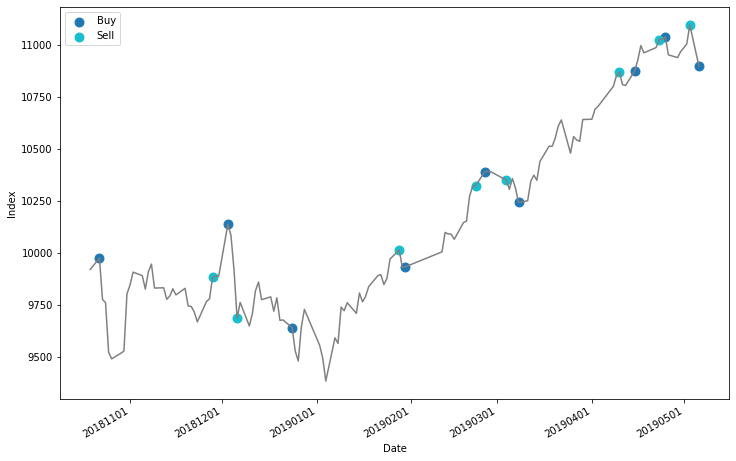

1.1826579541873083


In [47]:
# Valid
tmp = pd.read_csv('^TWII.csv')
tmp['Date'] = tmp['Date'].apply(lambda x:x.replace('-', ''))
tmp = price[price['Date']>'20140101']
tmp = tmp.dropna()

tmp = tmp[tmp['Date']<='20190506']
tmp = tmp[tmp['Date']>='20181019']

fig = plt.figure(figsize=(12, 8))

days = [datetime.strptime(x, '%Y%m%d') for x in list(tmp['Date'])]

ax1=fig.add_subplot(1,1,1)

ax1.plot(days, list(tmp['Adj Close']), c='gray')
plt.gcf().autofmt_xdate()

alldays =  mdates.MonthLocator()
ax1.xaxis.set_major_locator(alldays)        
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d')) 


ax1.scatter([days[x] for x in buy_time], [tmp.iloc[x]['Adj Close'] for x in buy_time], s=80, c = 'tab:blue', label='Buy')
ax1.scatter([days[x] for x in sell_time], [tmp.iloc[x]['Adj Close'] for x in sell_time], s=80, c = 'tab:cyan', label='Sell')
plt.xlabel('Date')
plt.ylabel('Index')

plt.legend()
plt.show()

print(max(tmp['Adj Close'])/min(tmp['Adj Close']))

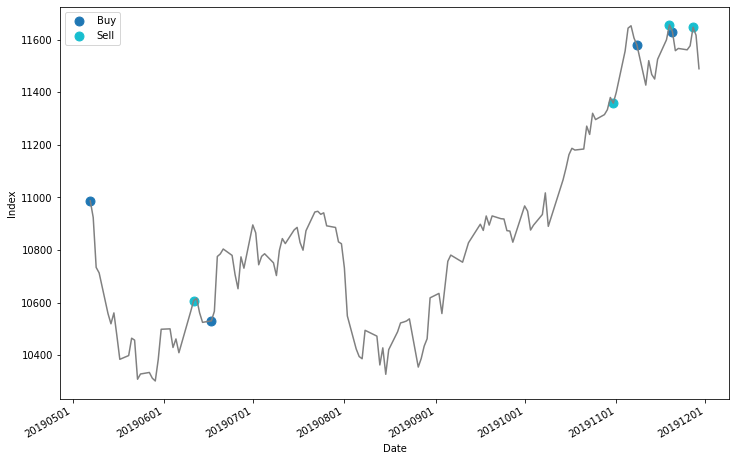

1.131493788656154


In [39]:
# Test
tmp = pd.read_csv('^TWII.csv')
tmp['Date'] = tmp['Date'].apply(lambda x:x.replace('-', ''))
tmp = price[price['Date']>'20140101']
tmp = tmp.dropna()

tmp = tmp[tmp['Date']<='20191129']
tmp = tmp[tmp['Date']>='20190507']
fig = plt.figure(figsize=(12, 8))

days = [datetime.strptime(x, '%Y%m%d') for x in list(tmp['Date'])]

ax1=fig.add_subplot(1,1,1)

ax1.plot(days, list(tmp['Adj Close']), c='gray')
plt.gcf().autofmt_xdate()

alldays =  mdates.MonthLocator()
ax1.xaxis.set_major_locator(alldays)        
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d')) 


ax1.scatter([days[x] for x in buy_time], [tmp.iloc[x]['Adj Close'] for x in buy_time], s=80, c = 'tab:blue', label='Buy')
ax1.scatter([days[x] for x in sell_time], [tmp.iloc[x]['Adj Close'] for x in sell_time], s=80, c = 'tab:cyan', label='Sell')
plt.xlabel('Date')
plt.ylabel('Index')

plt.legend()
plt.show()

print(max(tmp['Adj Close'])/min(tmp['Adj Close']))